# HOMEWORK 5: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

## Import Libs

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
from tqdm import tqdm
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

In [2]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    r = {}
    with open(filename, 'rb') as f:
        r = pickle.load(f)
    return r

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [3]:
data_df = pd.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [4]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [5]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'TrueMoney',
       'garbage', 'Payment', 'IDD', 'ringtone', 'Idd', 'rate',
       'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [6]:
# TODO1: Data cleaning
data_df.columns = ['input', 'action_label', 'object_label']

data_df['action_label']=data_df['action_label'].str.lower().copy()
data_df['object_label']=data_df['object_label'].str.lower().copy()

data_df = data_df.drop_duplicates("input", keep="first")
display(data_df.describe())

save_object(data_df, 'clean_data.pkl')

,input,action_label,object_label
count,13389,13389,13389
unique,13389,8,26
top,อยากสอบถามว่าโทรศัพท์มันเข้าอินเตอร์เน๊ตไม่ได้...,enquire,service
freq,1,8658,2111


In [7]:
data_df = load_object('clean_data.pkl')
display(data_df.action_label.unique())
display(data_df.object_label.unique())

data_df = data_df.reset_index(drop=True)
display(data_df)

array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'], dtype=object)

,input,action_label,object_label
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues
5,*2222 ใช้งานยังไง ขอรายละเอียดการสมัครหน่อย,enquire,service
6,<PHONE_NUMBER_REMOVED> เคยมีช่างมาซ่อมที่บ้าน ...,enquire,nontruemove
7,<PHONE_NUMBER_REMOVED> ค้างค่าบริการเท่าไหร่ครับ,enquire,balance
8,<PHONE_NUMBER_REMOVED> อินเตอร์เน็ตไฟ Adsl ไม่...,enquire,nontruemove
9,<PHONE_NUMBER_REMOVED> เค้าบอกจะส่งรหัสเน็ตมาใ...,enquire,internet


In [48]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Conv1D, TimeDistributed, Activation, Dense, concatenate, Flatten, GRU, Bidirectional, Dropout, LSTM, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing import sequence

CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

def get_tokenizer_model():
    input1 = Input(shape=(21,))
    x = Embedding(178,8)(input1)
    x = Conv1D(100,5,strides=1,activation='relu',padding="same")(x)
    x = TimeDistributed(Dense(5))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['acc'])
    return model

def create_n_gram_df(df, n_pad):
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df[0].shift(i + 1)
      df['char{}'.format(i+1)] = df[0].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

def tokenize(sentence, model):
    character = list(sentence)
    character_df = pd.DataFrame(character)

    n_pad = 21
    n_pad_2 = int((n_pad - 1)/2)
    pad = [{0: ' '}]
    df_pad = pd.DataFrame(pad * n_pad_2)

    character_df = pd.concat((df_pad, character_df, df_pad))
    character_df[0] = character_df[0].map(lambda x: CHARS_MAP.get(x, 80))
    
    df_with_context = create_n_gram_df(character_df, n_pad=n_pad)

    char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
                 ['char-' + str(i + 1) for i in range(n_pad_2)] + [0]

    x_char = df_with_context[char_row].as_matrix()
    y_pred = model.predict(x_char)

    prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
    y_pred = np.apply_along_axis(prob_to_class,1,y_pred)
    
    tokenize = []
    accumulator = ''
    for i in range(len(y_pred)):
        if(y_pred[i] == 1):
            tokenize.append(accumulator)
            accumulator = character[i]
        else:
            accumulator += character[i]
    else:
        tokenize.append(accumulator)
    tokenize = tokenize[1:]
    return tokenize

In [9]:
tokenizer_model = get_tokenizer_model()
tokenizer_model.summary()

tokenizer_path_model_best='/Users/Thipok/Documents/sideProject/NLP-course/HW5/tokenizer_model_best.h5'
tokenizer_model.load_weights(tokenizer_path_model_best)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 21, 8)             1424      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 100)           4100      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 5)             505       
_________________________________________________________________
flatten_1 (Flatten)          (None, 105)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10600     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [10]:
# # #Tokenize data
# length = len(data_df['input'])
# for x in tqdm(range(length)):
#     target = data_df['input'][x]
#     target = re.sub(r'[$|!|~|\n|-|+|%|@|$|^|&|=|:|:D|(|)|-|_|\t|?|;|\/|\\|\||{|}|\\]|\\[|`]|"|\'', r'', target)
#     tokenize_list = list(map(lambda x: re.sub('\s+','', x), list(filter(lambda x: len(x.strip()) \
#                 != 0 and x not in set(), tokenize(target, tokenizer_model)))))
#     data_df['input'][x] = tokenize_list

100%|██████████| 13389/13389 [03:03<00:00, 73.09it/s]


In [11]:
# save_object(data_df, 'tokenize_data.pkl')
display(data_df)

,input,action_label,object_label
0,"[<PHONENUMBERREMOVE>, ผม, ไป, จ่าย, เงิน, ที่,...",enquire,payment
1,"[internet, ยัง, ความ, เร็ว, อยุ่, เท่า, ไหร, ค...",enquire,package
2,"[ตะกี้, ไป, ชำระ, ค่า, บริการ, ไป, แล้ว, แต่, ...",report,suspend
3,"[พี่, ค่ะ, ยัง, ใช้, internet, ไม่, ได้, เลย, ...",enquire,internet
4,"[ฮาโหลคะ, พอดี, ว่า, เมื่อ, วาน, เปิด, ซิม, ทร...",report,phone_issues
5,"[*2222, ใช้, งาน, ยัง, ไง, ขอ, รายละเอียด, การ...",enquire,service
6,"[<PHONENUMBERREMOVE>, เคย, มี, ช่าง, มา, ซ่อม,...",enquire,nontruemove
7,"[<PHONENUMBERREMOVE>, ค้าง, ค่า, บริการ, เท่า,...",enquire,balance
8,"[<PHONENUMBERREMOVE>, อินเตอร์เน็ตไฟ, Adsl, ไม...",enquire,nontruemove
9,"[<PHONENUMBERREMOVE>, เค้า, บอก, จะ, ส่งรหัส, ...",enquire,internet


In [12]:
data_df = load_object('tokenize_data.pkl')

In [13]:
words = set()
rare_word = set()
word_freq = defaultdict(lambda: 0)
threshold = 1
num_UNK = 0

maxLen = 0

for sentence in data_df['input']:
    maxLen = max(maxLen, len(sentence))
    for w in sentence:
        word_freq[w] += 1

for x in word_freq:
    if(word_freq[x] <= threshold):
        num_UNK += word_freq[x]
        rare_word.add(x)
    else:
        words.add(x)

word_freq["UNK"] = num_UNK

In [14]:
print("Normal words to total unique words: {}%".format(100*len(words)/(len(words) + len(rare_word))))
print(maxLen)

Normal words to total unique words: 41.70972287458901%
109


In [15]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i+1

fileSave = "personalWord2Vec.pkl"

# word2vec = dict()
# filePath = "thai2vec.vec"
# fileLen = file_len(filePath)
# with open(filePath, 'r') as f:
#     for idx, line in tqdm(enumerate(f), total = fileLen):
#         if idx == 0:
#             continue
#         word2vec[line.split(' ')[0]] = [float(x) for x in line.split(' ')[1:]]
# save_object(word2vec, fileSave)

100%|██████████| 51359/51359 [00:06<00:00, 7618.97it/s]


In [16]:
word2vec = load_object(fileSave)

max_dim = 100
word_to_index = dict()
index_to_word = dict()
for idx, x in enumerate(word2vec.keys()):
    word_to_index[x] = idx
    index_to_word[idx] = x

In [17]:
#Prepare word embedding for unknown word

dictionary = dict()
dictionary_r = dict()

dictionary["for_keras_zero_padding"] = 0
dictionary_r[0] = "for_keras_zero_padding"

# rare_word = set()
word_threshold = 1

for word in word_freq:
    t = len(dictionary)
    dictionary[word] = t
    dictionary_r[t] = word
    
    if word_freq[word] <= word_threshold:
        rare_word.add(word)
        

data = list()
data_feature = []

for sentence in data_df['input']:
    for word in sentence:
        if word not in rare_word:
            data.append(dictionary[word])
        else:
            data.append(dictionary["UNK"])
    data_feature.append(data)
    data =[]

print(list(map(lambda lis: list(map(lambda y: dictionary_r[y], lis)), data_feature[:2])))

[['<PHONENUMBERREMOVE>', 'ผม', 'ไป', 'จ่าย', 'เงิน', 'ที่', 'UNK', 'Services', 'เค้า', 'เช็ต', 'UNK', '.', '25', 'บาท', 'เมื่อ', 'วาน', 'ที่', 'ผม', 'เช็ค', 'ที่', 'ศูนย์', 'บอก', 'มี', 'ยอด', 'UNK', '.', '79', 'บาท'], ['internet', 'ยัง', 'ความ', 'เร็ว', 'อยุ่', 'เท่า', 'ไหร', 'ครับ']]


In [18]:
#Create embedding Main train_data
pre_embedding = []
#For UNK word
pre_embedding.append(np.random.random(300))

for l in dictionary.keys():
    if l in word_to_index:
        pre_embedding.append(word2vec[l])
    else:
        pre_embedding.append(np.random.random(300)) 
weight_em = np.array(pre_embedding)

In [19]:
print(weight_em.shape)

(6390, 300)


In [20]:
x_train = sequence.pad_sequences(data_feature, maxlen=max_dim, padding='post', truncating='pre')
# np.random.shuffle(x_train)
print(x_train.shape)
print(list(map(lambda x: dictionary_r[x], x_train[0])))

(13389, 100)
['<PHONENUMBERREMOVE>', 'ผม', 'ไป', 'จ่าย', 'เงิน', 'ที่', 'UNK', 'Services', 'เค้า', 'เช็ต', 'UNK', '.', '25', 'บาท', 'เมื่อ', 'วาน', 'ที่', 'ผม', 'เช็ค', 'ที่', 'ศูนย์', 'บอก', 'มี', 'ยอด', 'UNK', '.', '79', 'บาท', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_padding', 'for_keras_zero_

## #TODO 2: Preprocessing data for Keras
You will be using Keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

In [21]:
# # TODO2: Preprocessing data for Keras

##Prepare data for training
input_data = x_train
splitter_idx = int(len(input_data)*0.8)
splitter_idx_2 = int(len(input_data)*0.9)
train_data = input_data[:splitter_idx]
val_data = input_data[splitter_idx:splitter_idx_2]
test_data = input_data[splitter_idx_2:]

action_label = list(data_df['action_label'])
y_train_action = pd.get_dummies(pd.Series(action_label)).as_matrix()

target = y_train_action
train_target_action = target[:splitter_idx]
val_target_action = target[splitter_idx:splitter_idx_2]
test_target_action = target[splitter_idx_2:]

object_label = list(data_df['object_label'])
y_train_label = pd.get_dummies(pd.Series(object_label)).as_matrix()

target = y_train_label
train_target_label = target[:splitter_idx]
val_target_label = target[splitter_idx:splitter_idx_2]
test_target_label = target[splitter_idx_2:]

## #TODO 3: Build and evaluate a model for "action" classification


In [129]:
#TODO 3: Build and evaluate a model for "action" classification
def get_my_best_model():
    input1 = Input(shape=(max_dim,))
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Conv1D(64,3,strides=1,activation='relu',padding="valid")(x)
    x = MaxPooling1D(pool_size=5, strides=1,padding='valid')(x)
    x = TimeDistributed(Dense(10))(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(8, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    return model

def get_my_test_model():
    input1 = Input(shape=(max_dim,))
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Bidirectional(LSTM(32))(x)
    x = Dense(3136, activation='softplus')(x)
    x = Reshape((98,32))(x)
    x = Conv1D(32,2,strides=1,activation='softplus',padding="valid")(x)
    x = MaxPooling1D(pool_size=2, strides=1,padding='valid')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(8, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    return model

def get_my_test_model_3():
    input1 = Input(shape=(max_dim,))
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Bidirectional(LSTM(32))(x)
    x = Dense(3136, activation='softplus')(x)
    x = Reshape((98,32))(x)
    x = Conv1D(32,2,strides=1,activation='softplus',padding="valid")(x)
    x = MaxPooling1D(pool_size=2, strides=1,padding='valid')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='softplus')(x)
    out = Dense(8, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    return model

model = get_my_test_model()
model.summary()

weight_path_model='Test_2.h5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 100, 300)          1917000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 64)                85248     
_________________________________________________________________
dense_57 (Dense)             (None, 3136)              203840    
_________________________________________________________________
reshape_17 (Reshape)         (None, 98, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 97, 32)            2080      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 96, 32)            0         
__________

In [1]:
%%time

callbacks_list_model = [
    ModelCheckpoint(
        weight_path_model,
        monitor = "val_loss",
        mode = 'min',
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
    )   
]

model.fit(train_data,train_target_action,
          batch_size=128,epochs=5,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_action))

NameError: name 'ModelCheckpoint' is not defined

In [116]:
model.fit(train_data,train_target_action,
          batch_size=128,epochs=5,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_action))

Train on 10711 samples, validate on 1339 samples
Epoch 1/5
10711/10711 [==============================] - 49s 5ms/step - loss: 0.4648 - categorical_accuracy: 0.8516 - val_loss: 0.5773 - val_categorical_accuracy: 0.8447
Epoch 2/5
10711/10711 [==============================] - 49s 5ms/step - loss: 0.3985 - categorical_accuracy: 0.8714 - val_loss: 0.5407 - val_categorical_accuracy: 0.8469
Epoch 3/5
10711/10711 [==============================] - 52s 5ms/step - loss: 0.3659 - categorical_accuracy: 0.8843 - val_loss: 0.5788 - val_categorical_accuracy: 0.8566
Epoch 4/5
10711/10711 [==============================] - 52s 5ms/step - loss: 0.3213 - categorical_accuracy: 0.8970 - val_loss: 0.5905 - val_categorical_accuracy: 0.8432
Epoch 5/5
10711/10711 [==============================] - 49s 5ms/step - loss: 0.2841 - categorical_accuracy: 0.9093 - val_loss: 0.6085 - val_categorical_accuracy: 0.8596


In [131]:
# model.save('test_action_model_3.h5')
# model.load_weights(weight_path_model)
model.load_weights('test_action_model.h5')
y_pred = model.predict(test_data)
predict_action = list(np.argmax(y_pred, axis=1))
real_action = list(np.argmax(test_target_action, axis=1))

Confusion matrix, without normalization
Normalized confusion matrix


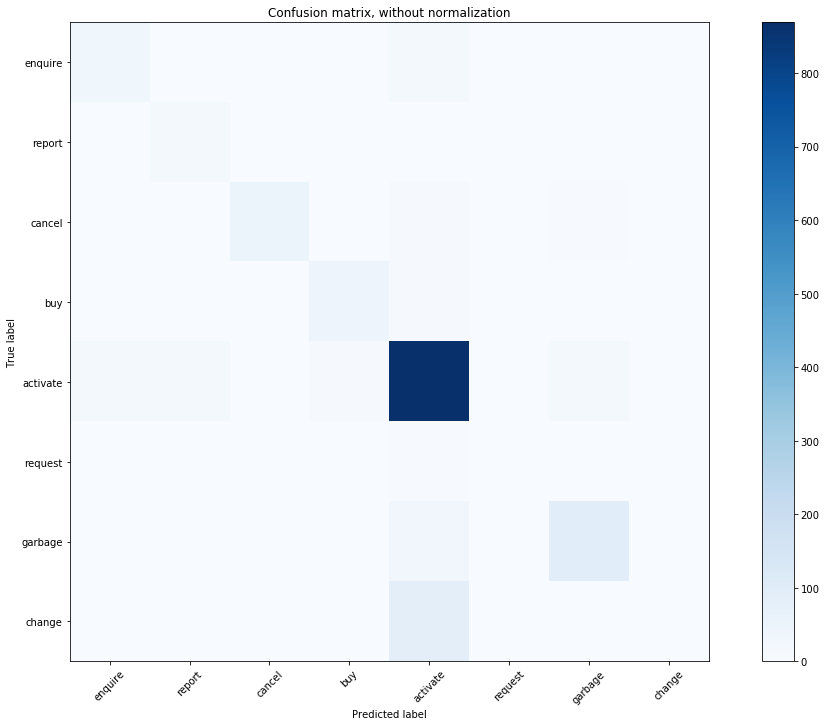

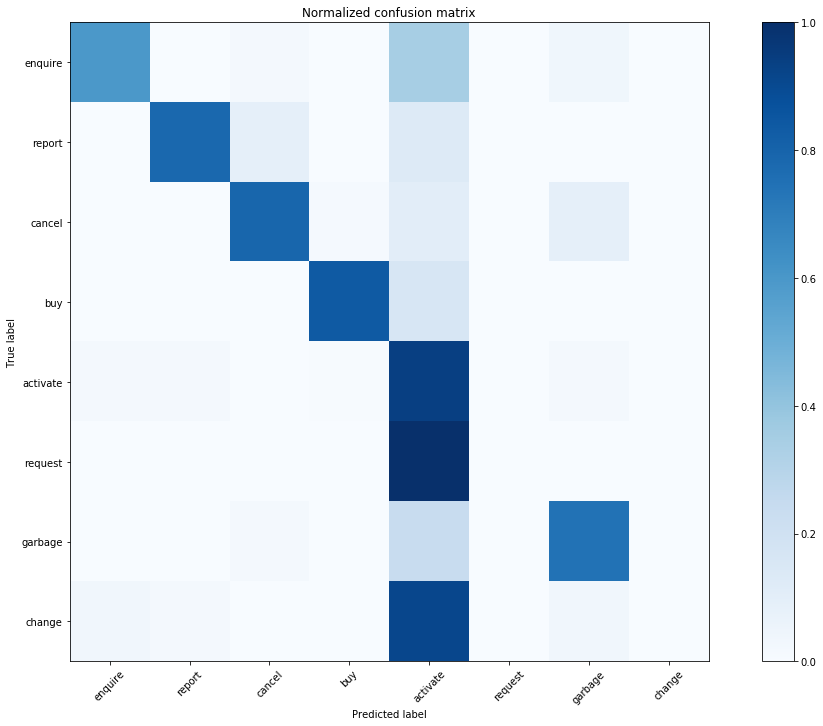

In [132]:
import itertools
from sklearn.metrics import confusion_matrix
#Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

unique_label = data_df['action_label'].unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = confusion_matrix(real_action, predict_action)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [133]:
correct = 0
for x in range(len(cnf_matrix)):
    correct += cnf_matrix[x][x]
print("Accuracy on test data: {}%".format(100*correct/cnf_matrix.sum()))

Accuracy on test data: 82.52427184466019%


## #TODO 4: Build and evaluate a model for "object" classification



In [57]:
#TODO 4: Build and evaluate a model for "object" classification
def get_my_best_model_object():
    input1 = Input(shape=(max_dim,))
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Conv1D(32,3,strides=1,activation='relu',padding="valid")(x)
    x = MaxPooling1D(pool_size=3, strides=1,padding='valid')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(26, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    return model

def get_my_test_model_object():
    input1 = Input(shape=(max_dim,))
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Bidirectional(GRU(32))(x)
    x = Dense(3136, activation='relu')(x)
    x = Reshape((98,32))(x)
    x = Conv1D(32,3,strides=1,activation='relu',padding="valid")(x)
    x = MaxPooling1D(pool_size=3, strides=1,padding='valid')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    out = Dense(26, activation='softmax')(x)
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    return model

# model = get_my_best_model_object()
model = get_my_test_model_object()
model.summary()

# weight_path_model='Test_object.h5'
weight_path_model='Test_object_test.h5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 100, 300)          1917000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                63936     
_________________________________________________________________
dense_21 (Dense)             (None, 3136)              203840    
_________________________________________________________________
reshape_4 (Reshape)          (None, 98, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 32)            3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 94, 32)            0         
__________

In [58]:
%%time

callbacks_list_model = [
    ModelCheckpoint(
        weight_path_model,
        monitor = "val_loss",
        mode = 'min',
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
    )   
]

model.fit(train_data,train_target_label,
          batch_size=128,epochs=3,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_label))

Train on 10711 samples, validate on 1339 samples
Epoch 1/3
10711/10711 [==============================] - 35s 3ms/step - loss: 2.4292 - categorical_accuracy: 0.2737 - val_loss: 1.8324 - val_categorical_accuracy: 0.4563
Epoch 2/3
10711/10711 [==============================] - 37s 3ms/step - loss: 1.6968 - categorical_accuracy: 0.4985 - val_loss: 1.3883 - val_categorical_accuracy: 0.5833
Epoch 3/3
10711/10711 [==============================] - 38s 4ms/step - loss: 1.3227 - categorical_accuracy: 0.6069 - val_loss: 1.2506 - val_categorical_accuracy: 0.6333
CPU times: user 7min 45s, sys: 2min 12s, total: 9min 58s
Wall time: 1min 50s


In [59]:
model.fit(train_data,train_target_label,
          batch_size=128,epochs=3,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_label))

Train on 10711 samples, validate on 1339 samples
Epoch 1/3
10711/10711 [==============================] - 38s 4ms/step - loss: 1.0885 - categorical_accuracy: 0.6730 - val_loss: 1.1653 - val_categorical_accuracy: 0.6311
Epoch 2/3
10711/10711 [==============================] - 49s 5ms/step - loss: 0.9396 - categorical_accuracy: 0.7188 - val_loss: 1.1552 - val_categorical_accuracy: 0.6550
Epoch 3/3
10711/10711 [==============================] - 53s 5ms/step - loss: 0.8035 - categorical_accuracy: 0.7507 - val_loss: 1.2285 - val_categorical_accuracy: 0.6453


In [70]:
model.fit(train_data,train_target_label,
          batch_size=128,epochs=3,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_label))

Train on 10711 samples, validate on 1339 samples
Epoch 1/3
10711/10711 [==============================] - 40s 4ms/step - loss: 0.7912 - categorical_accuracy: 0.7620 - val_loss: 1.1889 - val_categorical_accuracy: 0.6602
Epoch 2/3
10711/10711 [==============================] - 45s 4ms/step - loss: 0.7035 - categorical_accuracy: 0.7846 - val_loss: 1.2235 - val_categorical_accuracy: 0.6594
Epoch 3/3
10711/10711 [==============================] - 51s 5ms/step - loss: 0.6206 - categorical_accuracy: 0.8111 - val_loss: 1.2181 - val_categorical_accuracy: 0.6624


In [65]:
model.fit(train_data,train_target_label,
          batch_size=128,epochs=3,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, val_target_label))

Train on 10711 samples, validate on 1339 samples
Epoch 1/3
10711/10711 [==============================] - 43s 4ms/step - loss: 0.5464 - categorical_accuracy: 0.8313 - val_loss: 1.2875 - val_categorical_accuracy: 0.6535
Epoch 2/3
10711/10711 [==============================] - 46s 4ms/step - loss: 0.4718 - categorical_accuracy: 0.8532 - val_loss: 1.4202 - val_categorical_accuracy: 0.6505
Epoch 3/3
10711/10711 [==============================] - 49s 5ms/step - loss: 0.4215 - categorical_accuracy: 0.8683 - val_loss: 1.3579 - val_categorical_accuracy: 0.6505


In [73]:
# model.load_weights(weight_path_model)
model.save('Wow.h5')
y_pred = model.predict(test_data)
predict_object = list(np.argmax(y_pred, axis=1))
real_object = list(np.argmax(test_target_label, axis=1))

Confusion matrix, without normalization


/Users/Thipok/anaconda/envs/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix


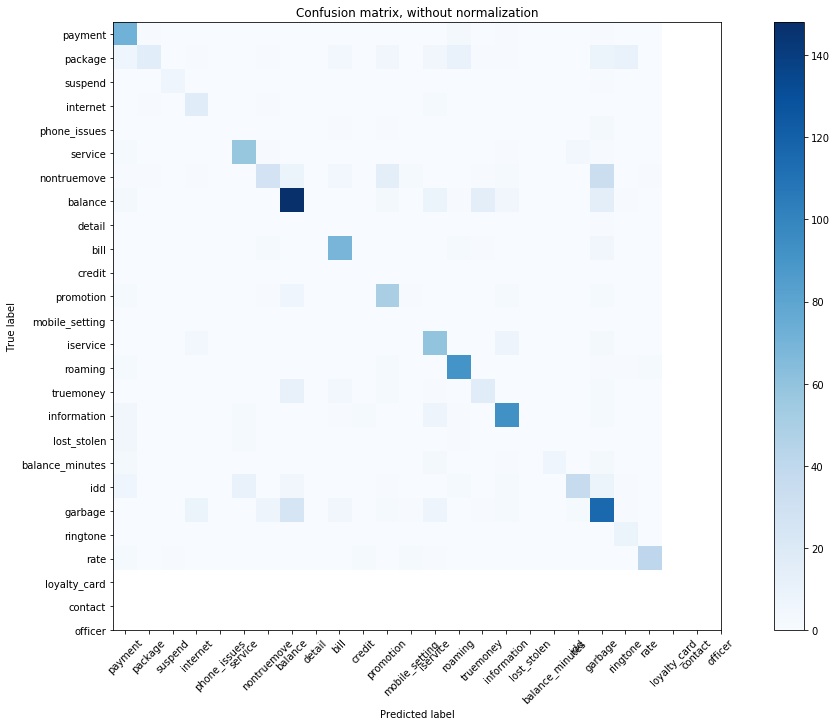

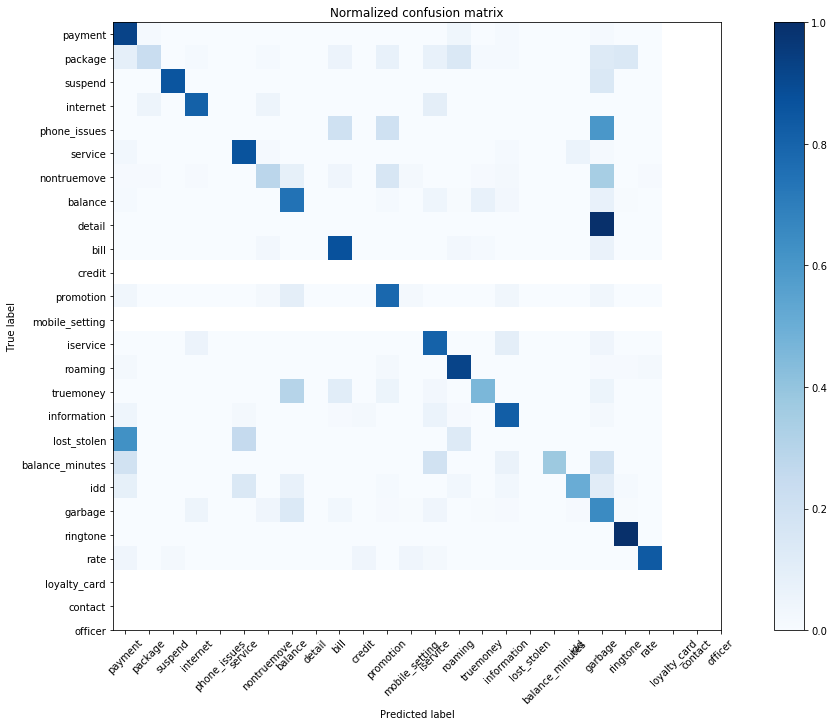

Accuracy on test data: 69.52949962658701%


In [74]:
unique_label = data_df['object_label'].unique()

cnf_matrix = confusion_matrix(real_object, predict_object)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

correct = 0
for x in range(len(cnf_matrix)):
    correct += cnf_matrix[x][x]
print("Accuracy on test data: {}%".format(100*correct/cnf_matrix.sum()))

## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ this webpage(https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
![image](https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW5/multitask_sketch.png)

In [242]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go
def get_my_best_model_both():
    input1 = Input(shape=(max_dim,), name='main_input')
    x = Embedding(weight_em.shape[0],300, weights = [weight_em])(input1)
    x = Conv1D(32,3,strides=1,activation='relu',padding="valid")(x)
    x = MaxPooling1D(pool_size=3, strides=1,padding='valid')(x)
    y = Bidirectional(LSTM(32))(x)
    y = Dense(100, activation='relu')(y)
    auxiliary_output = Dense(26, activation='sigmoid', name='aux_output')(y)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = concatenate([x, auxiliary_output])
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(50, activation='relu')(x)
    out = Dense(8, activation='softmax', name='main_output')(x)
    model = Model(inputs=input1, outputs=[out, auxiliary_output])
    model.compile(optimizer=Adam(),
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'],
                 loss_weights=[1., 0.2])
    return model

model = get_my_best_model_both()
model.summary()

weight_path_model='Test_both_test.h5'

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 100, 300)     1917000     main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 98, 32)       28832       embedding_42[0][0]               
__________________________________________________________________________________________________
max_pooling1d_39 (MaxPooling1D) (None, 96, 32)       0           conv1d_41[0][0]                  
__________________________________________________________________________________________________
bidirectio

In [243]:
%%time

callbacks_list_model = [
    ModelCheckpoint(
        weight_path_model,
        monitor = "val_loss",
        mode = 'min',
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
    )   
]

print(train_target_label.shape)

model.fit(train_data, [train_target_action, train_target_label],
          batch_size=128,epochs=3,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, [val_target_action, val_target_label]))

(10711, 26)
Train on 10711 samples, validate on 1339 samples
Epoch 1/3
10711/10711 [==============================] - 33s 3ms/step - loss: 1.7839 - main_output_loss: 1.2244 - aux_output_loss: 2.7974 - main_output_categorical_accuracy: 0.6400 - aux_output_categorical_accuracy: 0.1399 - val_loss: 1.2526 - val_main_output_loss: 0.7593 - val_aux_output_loss: 2.4666 - val_main_output_categorical_accuracy: 0.7849 - val_aux_output_categorical_accuracy: 0.2270
Epoch 2/3
10711/10711 [==============================] - 29s 3ms/step - loss: 1.2536 - main_output_loss: 0.7605 - aux_output_loss: 2.4654 - main_output_categorical_accuracy: 0.7607 - aux_output_categorical_accuracy: 0.2081 - val_loss: 1.0035 - val_main_output_loss: 0.5621 - val_aux_output_loss: 2.2069 - val_main_output_categorical_accuracy: 0.8402 - val_aux_output_categorical_accuracy: 0.3181
Epoch 3/3
10711/10711 [==============================] - 30s 3ms/step - loss: 0.9760 - main_output_loss: 0.5650 - aux_output_loss: 2.0549 - main_ou

In [254]:
%%time
model.fit(train_data, [train_target_action, train_target_label],
          batch_size=128,epochs=10,
          verbose=1,callbacks=callbacks_list_model,
          validation_data=(val_data, [val_target_action, val_target_label]))

Train on 10711 samples, validate on 1339 samples
Epoch 1/10
10711/10711 [==============================] - 28s 3ms/step - loss: 0.5527 - main_output_loss: 0.2944 - aux_output_loss: 1.2918 - main_output_categorical_accuracy: 0.9005 - aux_output_categorical_accuracy: 0.6211 - val_loss: 0.8286 - val_main_output_loss: 0.5446 - val_aux_output_loss: 1.4200 - val_main_output_categorical_accuracy: 0.8514 - val_aux_output_categorical_accuracy: 0.5833
Epoch 2/10
10711/10711 [==============================] - 35s 3ms/step - loss: 0.4952 - main_output_loss: 0.2573 - aux_output_loss: 1.1896 - main_output_categorical_accuracy: 0.9132 - aux_output_categorical_accuracy: 0.6446 - val_loss: 0.7769 - val_main_output_loss: 0.5014 - val_aux_output_loss: 1.3771 - val_main_output_categorical_accuracy: 0.8544 - val_aux_output_categorical_accuracy: 0.5833
Epoch 3/10
10711/10711 [==============================] - 36s 3ms/step - loss: 0.4525 - main_output_loss: 0.2305 - aux_output_loss: 1.1100 - main_output_cate

In [255]:
# model.load_weights(weight_path_model)
y_pred_action, y_pred_object = model.predict(test_data)
y_pred_action = list(np.argmax(y_pred_action, axis=1))
y_pred_object = list(np.argmax(y_pred_object, axis=1))
print(y_pred_action[:10])
print(y_pred_object[:10])

[2, 4, 4, 2, 4, 0, 4, 4, 4, 4]
[23, 22, 19, 23, 7, 23, 23, 9, 9, 13]


Confusion matrix, without normalization
Normalized confusion matrix


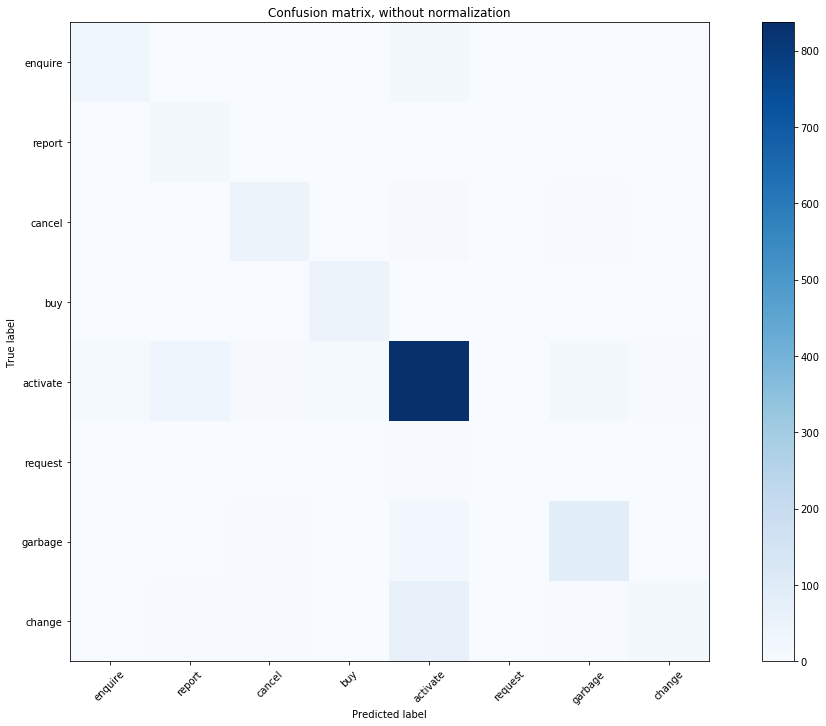

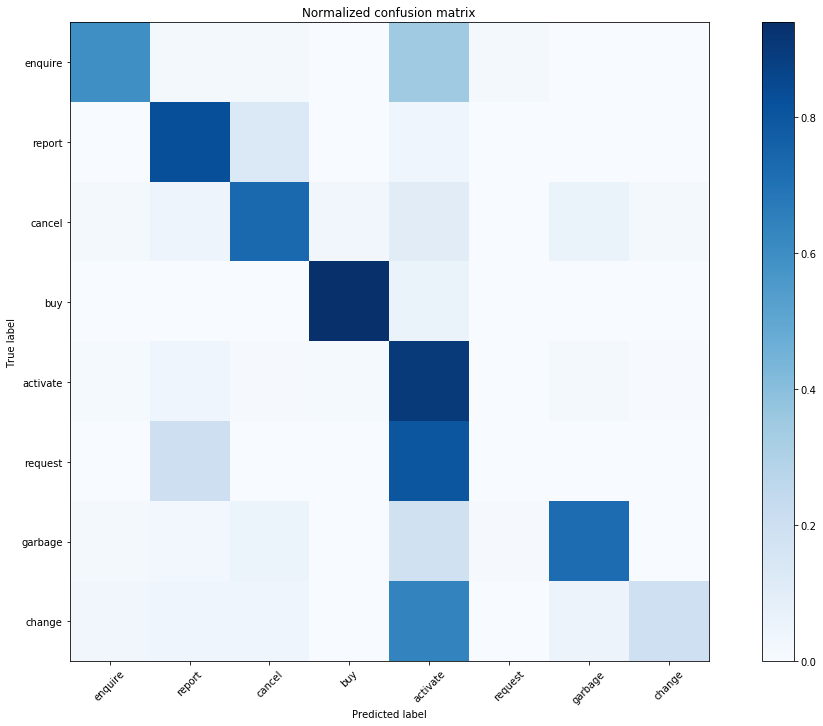

Accuracy on test data: 81.40403286034353%
Confusion matrix, without normalization


/Users/Thipok/anaconda/envs/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Normalized confusion matrix


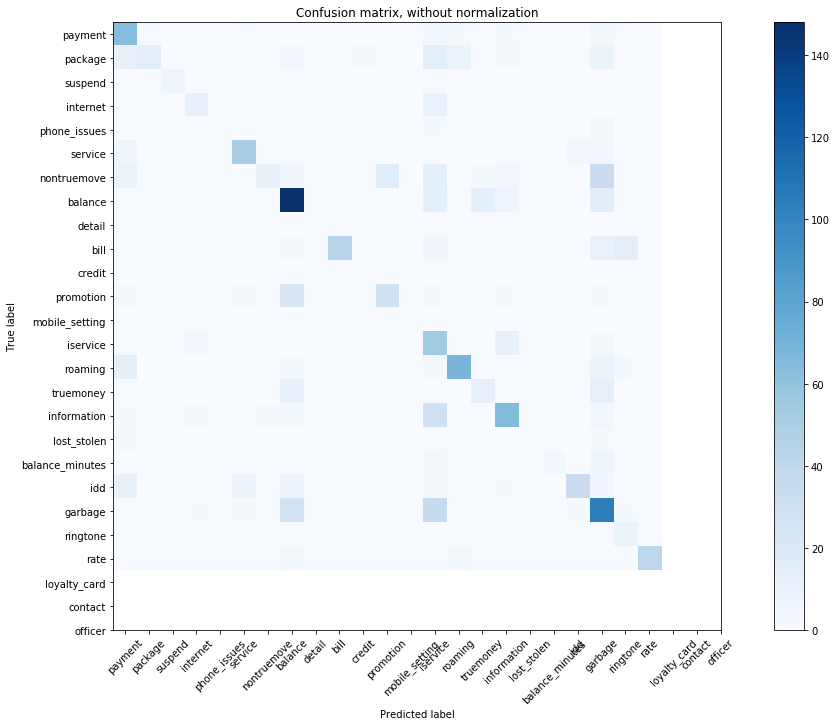

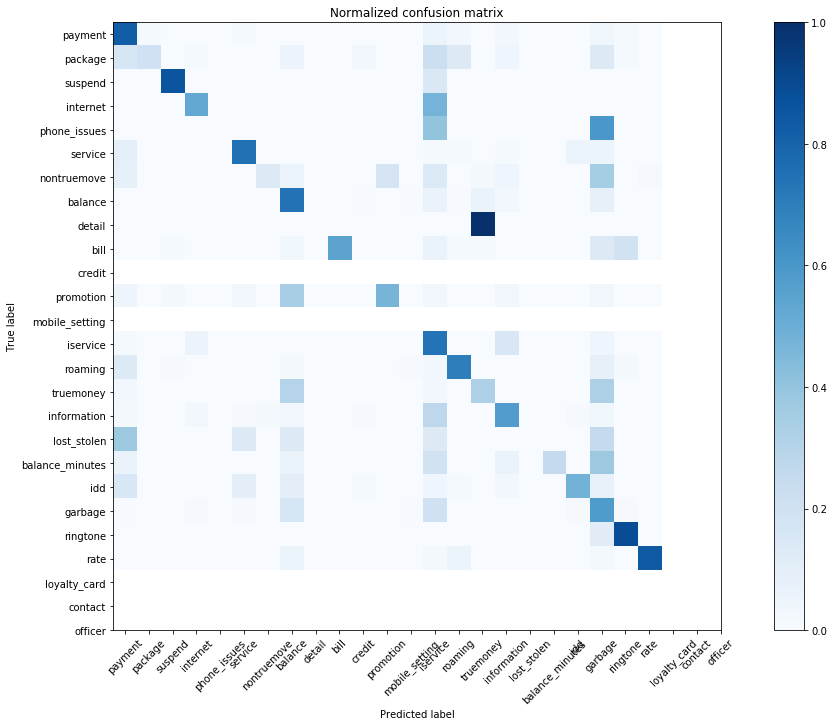

Accuracy on test data: 57.43091859596714%


In [256]:
unique_action = data_df['action_label'].unique()
unique_label = data_df['object_label'].unique()

cnf_matrix = confusion_matrix(real_action, y_pred_action)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_action,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_action, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

correct = 0
for x in range(len(cnf_matrix)):
    correct += cnf_matrix[x][x]
print("Accuracy on test data: {}%".format(100*correct/cnf_matrix.sum()))

cnf_matrix = confusion_matrix(real_object, y_pred_object)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=unique_label, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

correct = 0
for x in range(len(cnf_matrix)):
    correct += cnf_matrix[x][x]
print("Accuracy on test data: {}%".format(100*correct/cnf_matrix.sum()))